**Shashi Sharma, ss139529@gmail.com**

# Amazon Fine Food Reviews Analysis_NB


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets, neighbors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler


C:\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# Here we are ordering the time column in desc order as AFR is a time series data.


filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score !=3 ORDER BY TIME DESC LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
ActualScore = filtered_data['Score']
positiveNegative = ActualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(5)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,1,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...
1,1089,B004FD13RW,A1BPLP0BKERV,Paul,0,0,1,1351209600,It is awesome.,"My partner is very happy with the tea, and is ..."
2,5703,B009WSNWC4,AMP7K1O84DH1T,ESTY,0,0,1,1351209600,DELICIOUS,Purchased this product at a local store in NY ...
3,5924,B00523NRVO,A2JDXKFZ0PFHKU,James W. Shondel,0,0,1,1351209600,The perfect pop!,"These lollipops are are well done, look exactl..."
4,7178,B004OQLIHK,AKHQMSUORSA91,Pen Name,0,0,1,1351209600,Delicious!,I have ordered these raisins multiple times. ...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head() #BY DEFAULT IT DISPLAY 5 ROWS

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time", "Text"}, keep='first', inplace=False)
final.shape

(71551, 10)

In [10]:
#Sorting data according to Time in descending order
final=final.sort_values('Time', axis=0, ascending=False)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

71.551

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)
Score=final['Score']
#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(71551, 10)


1    59256
0    12295
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

You can taste the butter.  The peanuts are fresh.  Each piece of See's Peanut Brittle is a nice size and the flavor is yummy.  If you are a prime member it ships at no additional charge.  Great deal!
We have ordered these through Amazon twice now, and have been very satisfied both times.  We've had no problems with expiration dates, and the product is good--the anchovies are whole, and have good flavor.  If you use a lot of anchovies, this is a very convenient way to purchase and store them.
The product was just what I expected. A large amount of yummy candy corn! I purchased it for the candy buffet I had at my wedding reception & we still have some leftover. My husband is now eating a little every day.
<a href="http://www.amazon.com/gp/product/B001EO7GKI">Roland Olives Stuffed With Anchovies, 1-Pound 9-Ounces Dry Weight Cans (Pack of 2)</a><br />NASTY!!!! Don't bother wasting your $$$$$ on this product!!!!. I was looking forward to getting this product.<br />When I opened the first ca

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

You can taste the butter.  The peanuts are fresh.  Each piece of See's Peanut Brittle is a nice size and the flavor is yummy.  If you are a prime member it ships at no additional charge.  Great deal!


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

You can taste the butter.  The peanuts are fresh.  Each piece of See's Peanut Brittle is a nice size and the flavor is yummy.  If you are a prime member it ships at no additional charge.  Great deal!
We have ordered these through Amazon twice now, and have been very satisfied both times.  We've had no problems with expiration dates, and the product is good--the anchovies are whole, and have good flavor.  If you use a lot of anchovies, this is a very convenient way to purchase and store them.
The product was just what I expected. A large amount of yummy candy corn! I purchased it for the candy buffet I had at my wedding reception & we still have some leftover. My husband is now eating a little every day.



In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

The product was just what I expected. A large amount of yummy candy corn! I purchased it for the candy buffet I had at my wedding reception & we still have some leftover. My husband is now eating a little every day.


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

You can taste the butter.  The peanuts are fresh.  Each piece of See's Peanut Brittle is a nice size and the flavor is yummy.  If you are a prime member it ships at no additional charge.  Great deal!


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

The product was just what I expected A large amount of yummy candy corn I purchased it for the candy buffet I had at my wedding reception we still have some leftover My husband is now eating a little every day 


In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z0-9]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(word.lower() for word in sentance.split() if word.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 71551/71551 [01:04<00:00, 1111.08it/s]


In [24]:
#comparing the raw data and the preprocessed data:

print(sent_0) 
print("####")
print(preprocessed_reviews[0])

You can taste the butter.  The peanuts are fresh.  Each piece of See's Peanut Brittle is a nice size and the flavor is yummy.  If you are a prime member it ships at no additional charge.  Great deal!
####
taste butter peanuts fresh piece see peanut brittle nice size flavor yummy prime member ships no additional charge great deal


In [25]:
preprocessed_reviews[1500]

'product expected large amount yummy candy corn purchased candy buffet wedding reception still leftover husband eating little every day'

In [26]:
# printing some random summary
summ_0 = final['Summary'].values[0]
print(summ_0)
print("="*50)

summ_1000 = final['Summary'].values[1000]
print(summ_1000)
print("="*50)

Yummy
Excellent quality


In [27]:
## preprocessing the review summary to be use for feature engineering later. 
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in (final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())


C:\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Anaconda3\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should pr

In [28]:
preprocessed_summary[1500]

'love candy corn'

# [4] Featurization

#### Splitting the preprocessed_reviews data:

In [29]:
Y = Score
X= preprocessed_reviews

In [30]:
np.shape(X)

(71551,)

In [31]:
np.shape(Y)

(71551,)

In [32]:
# Slicing the Data X and Y into X_train, X_test, y_train and y_test
# making sure not to use train_test_split as it would randomly split points and disturb the sorting
X_train= X[0:50086]
X_test= X[50086:]
y_train= Y[0:50086]
y_test= Y[50086:]

In [33]:
print(np.shape(X_train), np.shape(y_train))
print(np.shape(X_test), np.shape(y_test))


(50086,) (50086,)
(21465,) (21465,)


## [4.1] BAG OF WORDS

In [34]:
#BoW
count_vect = CountVectorizer()
count_vect.fit(X_train) # fit has to happen only on train data
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

X_train_bow = count_vect.transform(X_train)
X_test_bow = count_vect.transform(X_test)

print("the type of count vectorizer ",type(X_train_bow))
print("the number of unique words in X_train",X_train_bow.shape[1])
print('='*50)
print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_test_bow.shape, y_test.shape)
print("="*50)

some feature names  ['aa', 'aaa', 'aaaaa', 'aaaaaaah', 'aaaaaahhhhh', 'aaaahhhhhhhhhhh', 'aaaannnnddd', 'aaah', 'aaahs', 'aafco']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the number of unique words in X_train 42085
After vectorizations
(50086, 42085) (50086,)
(21465, 42085) (21465,)


In [35]:
len(count_vect.get_feature_names())

42085

## [4.3] TF-IDF

In [36]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train)
print('='*50)

X_train_tfidf = tf_idf_vect.transform(X_train)
X_test_tfidf = tf_idf_vect.transform(X_test)
print("the type of tf_idf_vect",type(X_train_tfidf))
print('='*50)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_test_tfidf.shape, y_test.shape)
print('='*50)
print("The number of unique words in tf_idf_vect of X_train ", X_train_tfidf.shape[1])

the type of tf_idf_vect <class 'scipy.sparse.csr.csr_matrix'>
After vectorizations
(50086, 28670) (50086,)
(21465, 28670) (21465,)
The number of unique words in tf_idf_vect of X_train  28670


# [5] Assignment 4: Apply Naive Bayes


<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using values of `feature_log_prob_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

In [37]:
# We can apply Naive Bayes only on positive values so we will only use BOW and TFIDF.

### [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [38]:
from sklearn import naive_bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import Normalizer

In [39]:
# Please write all the code with proper documentation
# Normalizing both X_TRAIN_BOW AND X_TEST_BOW
Normal = Normalizer(copy=True, norm='l2').fit(X_train_bow) # Fitting the Normalizer only to train data to avoid data leakage.
X_train_bow_S = Normal.transform(X_train_bow)
X_test_bow_S = Normal.transform(X_test_bow)

In [40]:
# Using Grid search method to find the optimal K.
# Setting class_prior = [0.5,0.5] deal with the imbalance dataset in NB.
from sklearn.model_selection import GridSearchCV
NB = MultinomialNB(class_prior = [0.5,0.5], fit_prior=True)
a= [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000]
parameters = {'alpha':a}
clf = GridSearchCV(NB, parameters, cv=3, scoring='roc_auc', return_train_score= True )
clf= clf.fit(X_train_bow_S, y_train)

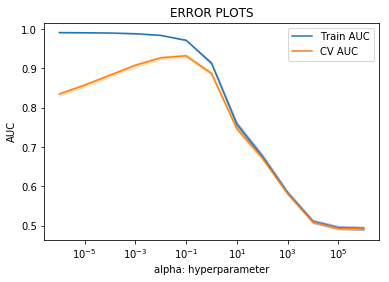

In [41]:
#Plotting performance of model both on train data and cross validation, and finding the best optimum K.
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

# As alpha values range from very low to very high value.
# So we used pyplot.semilogx to convert alpha to log(alpha) for easy interpretation

plt.semilogx(a, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(a,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.semilogx(a, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(a,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [43]:
l=0
for i in a:
    print (i,train_auc[l],cv_auc[l],train_auc[l]-cv_auc[l] )
    l+=1

1e-06 0.9907835454043719 0.8345037643926615 0.15627978101171036
1e-05 0.9903853507273581 0.8572754170926474 0.1331099336347107
0.0001 0.989625807235586 0.8824207977450932 0.10720500949049283
0.001 0.9879719151697892 0.9075714944018112 0.08040042076797804
0.01 0.9837281360234144 0.9265592314116018 0.057168904611812565
0.1 0.9712868151320615 0.931739478623488 0.03954733650857345
1 0.9130938056792172 0.8868979221247365 0.02619588355448066
10 0.7581832283446172 0.7468438982513669 0.011339330093250277
100 0.6771024069330673 0.6723597082287568 0.004742698704310544
1000 0.5841973996309321 0.5817225918640154 0.0024748077669166646
10000 0.5111405116091459 0.5093640402978366 0.0017764713113093134
100000 0.4953902485710866 0.4937284450056959 0.001661803565390696
1000000 0.49361566311850485 0.49196955215820753 0.00164611096029732


In [44]:
## From the plot and for loop, it's very clear that the optimal alpha is 0.1

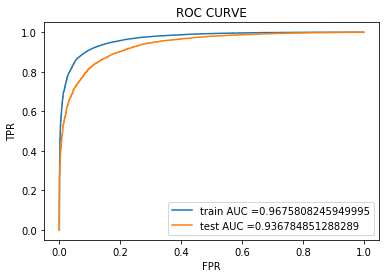

In [45]:
#training our model with the best optimal alpha as 10, and find the AUC on test data and plot the ROC curve on both train and test. 
NBbow = MultinomialNB(alpha=0.1, class_prior= [0.5,0.5], fit_prior=True)
NBbow.fit(X_train_bow_S, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, NBbow.predict_proba(X_train_bow_S)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, NBbow.predict_proba(X_test_bow_S)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.show()

Train confusion matrix


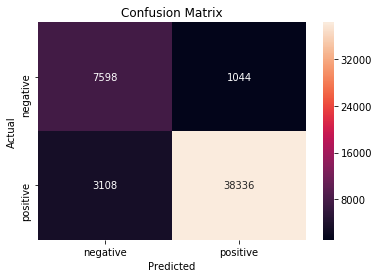

Test confusion matrix


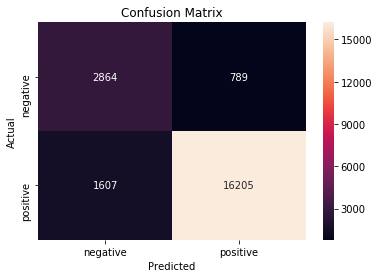

In [46]:
# Confusion matrix
print("Train confusion matrix")
matrix_train= confusion_matrix(y_train, NBbow.predict(X_train_bow_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train = pd.DataFrame(matrix_train,columns,index)
sns.heatmap(df_matrix_train, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Test confusion matrix")
matrix_test= confusion_matrix(y_test, NBbow.predict(X_test_bow_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_test = pd.DataFrame(matrix_test,columns,index)
sns.heatmap(df_matrix_test, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [47]:
# Please write all the code with proper documentation
feat_prob = NBbow.feature_log_prob_ #log probability of the features.
feat_name = count_vect.get_feature_names()
positive_feat = np.argsort(feat_prob[1])[::-1] #Returns sorted indexs of +ve class.
print("Top 10 positive features from BOW:")
for i in list(positive_feat[0:10]):
    print(feat_name[i])

Top 10 positive features from BOW:
not
great
good
like
love
product
taste
coffee
one
flavor


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [48]:
# Please write all the code with proper documentation
negative_feat = np.argsort(feat_prob[0])[::-1]
print("Top 10 Negative features from BOW:")
for i in list(negative_feat[0:10]):
    print(feat_name[i])

Top 10 Negative features from BOW:
not
like
product
would
taste
one
good
no
flavor
coffee


## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [49]:
# Please write all the code with proper documentation
# Standadizing both X_TRAIN_TFID AND X_TEST_TFIDF
Normal1 = Normalizer(copy=True, norm='l2').fit(X_train_tfidf) # Fitting the Normalizer only to train data to avoid data leakage.
X_train_tfidf_S = Normal1.transform(X_train_tfidf)
X_test_tfidf_S= Normal1.transform(X_test_tfidf)

In [50]:
# Using Grid search method to find the optimal K.
NB = MultinomialNB(class_prior=[0.5,0.5], fit_prior=True)
a= [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000]
parameters = {'alpha':a}
clf1 = GridSearchCV(NB, parameters, cv=3, scoring='roc_auc', return_train_score= True )
clf1= clf1.fit(X_train_tfidf_S, y_train)

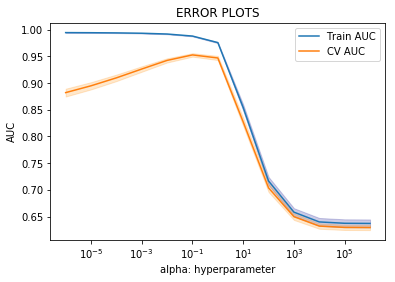

In [51]:
#Plotting performance of model both on train data and cross validation, and finding the best optimum K.
train_auc1= clf1.cv_results_['mean_train_score']
train_auc_std1= clf1.cv_results_['std_train_score']
cv_auc1 = clf1.cv_results_['mean_test_score'] 
cv_auc_std1= clf1.cv_results_['std_test_score']

# As alpha values range from very low to very high value.
# So we used pyplot.semilogx to convert alpha to log(alpha) for easy interpretation

plt.semilogx(a, train_auc1, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(a,train_auc1 - train_auc_std1,train_auc1 + train_auc_std1,alpha=0.2,color='darkblue')

plt.semilogx(a, cv_auc1, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(a,cv_auc1 - cv_auc_std1,cv_auc1 + cv_auc_std1,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [53]:
l=0
for i in a:
    print (i,train_auc1[l],cv_auc1[l],train_auc1[l]-cv_auc1[l] )
    l+=1

1e-06 0.9943582799585555 0.8819893319209885 0.11236894803756703
1e-05 0.9941662176694729 0.8947823905298141 0.09938382713965876
0.0001 0.9938245000948392 0.9096359730831833 0.08418852701165591
0.001 0.9931617565964351 0.9261490005826877 0.06701275601374745
0.01 0.9917094933686769 0.9423255252382137 0.049383968130463196
0.1 0.9878842196825047 0.9525877517369143 0.03529646794559038
1 0.9756381792030099 0.9468433519469562 0.028794827256053646
10 0.8540605407524827 0.8270152559187968 0.027045284833685956
100 0.7164177821655736 0.7035690215060654 0.01284876065950824
1000 0.6581442877482576 0.6496548269363802 0.008489460811877403
10000 0.6398383780760919 0.6320995800762795 0.0077387979998123635
100000 0.6373029593574048 0.6296414836841399 0.007661475673264917
1000000 0.6370374074686316 0.6293870682257905 0.007650339242841087


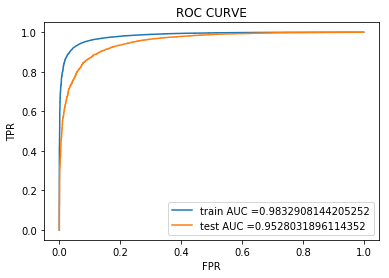

In [54]:
#training our model with the best optimal alpha as 0.1, and find the AUC on test data and plot the ROC curve on both train and test. 
NBtfidf = MultinomialNB(alpha=0.1, class_prior=[0.5,0.5], fit_prior=True)
NBtfidf.fit(X_train_tfidf_S, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr1, train_tpr1, thresholds1 = roc_curve(y_train, NBtfidf.predict_proba(X_train_tfidf_S)[:,1])
test_fpr1, test_tpr1, thresholds1 = roc_curve(y_test, NBtfidf.predict_proba(X_test_tfidf_S)[:,1])

plt.plot(train_fpr1, train_tpr1, label="train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(test_fpr1, test_tpr1, label="test AUC ="+str(auc(test_fpr1, test_tpr1)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.show()

Train confusion matrix


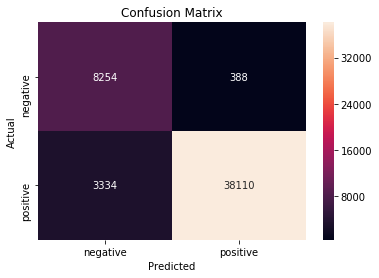

Test confusion matrix


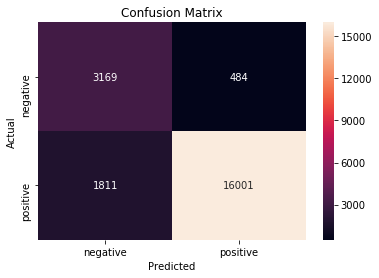

In [55]:
# Confusion matrix
print("Train confusion matrix")
matrix_train1= confusion_matrix(y_train, NBtfidf.predict(X_train_tfidf_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train1 = pd.DataFrame(matrix_train1,columns,index)
sns.heatmap(df_matrix_train1, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Test confusion matrix")
matrix_test1= confusion_matrix(y_test, NBtfidf.predict(X_test_tfidf_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_test1 = pd.DataFrame(matrix_test1,columns,index)
sns.heatmap(df_matrix_test1, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [56]:
# Please write all the code with proper documentation
feat_prob1 = NBtfidf.feature_log_prob_ #log probability of the features.
feat_name1 = tf_idf_vect.get_feature_names()
positive_feat1 = np.argsort(feat_prob1[1])[::-1] #Returns sorted indexs of +ve class.
print("Top 10 positive features from BOW:")
for i in list(positive_feat1[0:10]):
    print(feat_name1[i])

Top 10 positive features from BOW:
not
great
good
like
coffee
love
product
tea
taste
one


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [57]:
# Please write all the code with proper documentation
negative_feat1 = np.argsort(feat_prob1[0])[::-1]
print("Top 10 Negative features from BOW:")
for i in list(negative_feat1[0:10]):
    print(feat_name1[i])

Top 10 Negative features from BOW:
not
product
like
would
taste
one
no
coffee
buy
flavor


### [6.1] Feature engineering: Applying Naive Bayes on BOW,<font color='red'> SET 3</font>

In [58]:
# Finding the lenght of the review:
Review_len = [len(sentence.split()) for sentence in preprocessed_reviews]

In [59]:
Review_len[1500]

19

In [60]:
preprocessed_reviews[1500]

'product expected large amount yummy candy corn purchased candy buffet wedding reception still leftover husband eating little every day'

In [61]:
#Adding review length and summary to preprocessed_review as the part of Feature engineering:
preprocessed_reviews1= []
for i in range(len(preprocessed_reviews)):
    preprocessed_reviews[i]+=' '+preprocessed_summary[i]+' '+str(Review_len[i])
    preprocessed_reviews1.append(preprocessed_reviews[i])

In [62]:
preprocessed_reviews1[1500]

'product expected large amount yummy candy corn purchased candy buffet wedding reception still leftover husband eating little every day love candy corn 19'

In [63]:
X1= preprocessed_reviews1
Y1 = Score

In [64]:
# Slicing the Data X and Y into X_train, X_test, y_train and y_test
# making sure not to use train_test_split as it would randomly split points and disturb the sorting
X1_train= X1[0:50086]
X1_test= X1[50086:]
y1_train= Y1[0:50086]
y1_test= Y1[50086:]

In [65]:
#BoW
count_vect1 = CountVectorizer()
count_vect1.fit(X1_train) # fit has to happen only on train data

X_train_fe_bow = count_vect1.transform(X1_train)
X_test_fe_bow = count_vect1.transform(X1_test)

print("the type of count vectorizer ",type(X_train_fe_bow))
print("the number of unique words in X_train_fe",X_train_fe_bow.shape[1])
print('='*50)
print("After vectorizations")
print(X_train_fe_bow.shape, y1_train.shape)
print(X_test_fe_bow.shape, y1_test.shape)
print("="*50)

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the number of unique words in X_train_fe 44014
After vectorizations
(50086, 44014) (50086,)
(21465, 44014) (21465,)


In [66]:
X_train_fe_bow

<50086x44014 sparse matrix of type '<class 'numpy.int64'>'
	with 1734471 stored elements in Compressed Sparse Row format>

In [67]:
# Normalizing both X_TRAIN_BOW AND X_TEST_BOW
Normal2 = Normalizer(copy=True, norm='l2').fit(X_train_fe_bow) # Fitting the Normalizer only to train data to avoid data leakage.
X_train_fe_bow_S = Normal2.transform(X_train_fe_bow)
X_test_fe_bow_S = Normal2.transform(X_test_fe_bow)

In [68]:
# Using Grid search method to find the optimal K.
from sklearn.model_selection import GridSearchCV
NB = MultinomialNB(class_prior=[0.5,0.5], fit_prior=True)
a= [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000]
parameters = {'alpha':a}
clf2 = GridSearchCV(NB, parameters, cv=3, scoring='roc_auc', return_train_score= True )
clf2= clf2.fit(X_train_fe_bow_S, y1_train)

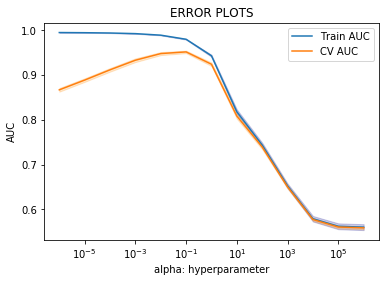

In [69]:
#Plotting performance of model both on train data and cross validation, and finding the best optimum K.
train_auc2= clf2.cv_results_['mean_train_score']
train_auc_std2= clf2.cv_results_['std_train_score']
cv_auc2 = clf2.cv_results_['mean_test_score'] 
cv_auc_std2= clf2.cv_results_['std_test_score']

# As alpha values range from very low to very high value.
# So we used pyplot.semilogx to convert alpha to log(alpha) for easy interpretation

plt.semilogx(a, train_auc2, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(a,train_auc2 - train_auc_std2,train_auc2 + train_auc_std2,alpha=0.2,color='darkblue')

plt.semilogx(a, cv_auc2, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(a,cv_auc2 - cv_auc_std2,cv_auc2 + cv_auc_std2,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [70]:
l=0
for i in a:
    print (i,train_auc2[l],cv_auc2[l],train_auc2[l]-cv_auc2[l] )
    l+=1

1e-06 0.9941958544390022 0.8665081685831983 0.1276876858558038
1e-05 0.9938347689196387 0.8882757630877874 0.1055590058318513
0.0001 0.9931685935334764 0.911116030988628 0.08205256254484838
0.001 0.9917753879512347 0.9325254286106549 0.05924995934057975
0.01 0.9883460303044691 0.9473188608287283 0.04102716947574081
0.1 0.9791945452360533 0.9510722323689093 0.02812231286714406
1 0.9424138711502383 0.9235182389855261 0.01889563216471224
10 0.8177205320700377 0.8080279944590776 0.009692537610960117
100 0.7435023387616724 0.739131087312547 0.004371251449125424
1000 0.6526240139503243 0.6502864916841246 0.0023375222661997652
10000 0.5792898764175868 0.5775789897689477 0.001710886648639054
100000 0.5624959915051805 0.5608903654694029 0.0016056260357776297
1000000 0.5605643698455316 0.5589656585752936 0.001598711270238029


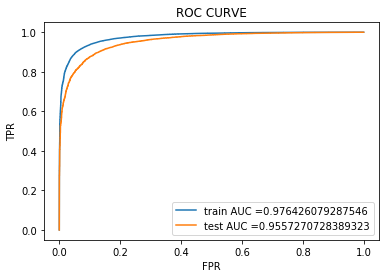

In [71]:
#training our model with the best optimal a, and find the AUC on test data and plot the ROC curve on both train and test. 
NBbow1 = MultinomialNB(alpha=0.1, class_prior=[0.5,0.5], fit_prior=True)
NBbow1.fit(X_train_fe_bow_S, y1_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr2, train_tpr2, thresholds2 = roc_curve(y1_train, NBbow1.predict_proba(X_train_fe_bow_S)[:,1])
test_fpr2, test_tpr2, thresholds2 = roc_curve(y1_test, NBbow1.predict_proba(X_test_fe_bow_S)[:,1])

plt.plot(train_fpr2, train_tpr2, label="train AUC ="+str(auc(train_fpr2, train_tpr2)))
plt.plot(test_fpr2, test_tpr2, label="test AUC ="+str(auc(test_fpr2, test_tpr2)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.show()

Train confusion matrix:


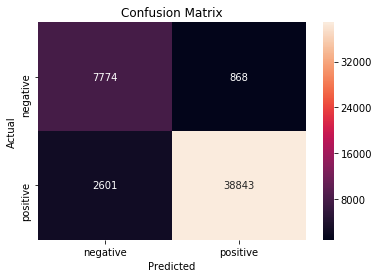

Test confusion matrix:


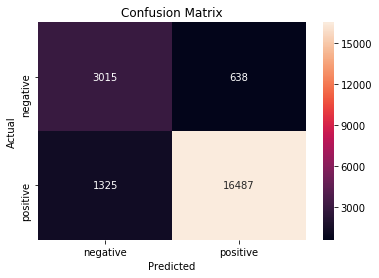

In [72]:
# Confusion matrix
print("Train confusion matrix:")
matrix_train2= confusion_matrix(y1_train, NBbow1.predict(X_train_fe_bow_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train2 = pd.DataFrame(matrix_train2,columns,index)
sns.heatmap(df_matrix_train2, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Test confusion matrix:")
matrix_test2= confusion_matrix(y1_test, NBbow1.predict(X_test_fe_bow_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_test2 = pd.DataFrame(matrix_test2,columns,index)
sns.heatmap(df_matrix_test2, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [73]:
# Top 10 important features of positive class.
# Please write all the code with proper documentation
feat_prob2 = NBbow1.feature_log_prob_ #log probability of the features.
feat_name2 = count_vect1.get_feature_names()
positive_feat2 = np.argsort(feat_prob2[1])[::-1] #Returns sorted indexs of +ve class.
print("Top 10 positive features from BOW:")
for i in list(positive_feat2[0:10]):
    print(feat_name2[i])

Top 10 positive features from BOW:
not
great
good
like
love
product
coffee
taste
one
flavor


In [74]:
# Top 10 important features of negative class.
# Please write all the code with proper documentation
negative_feat2 = np.argsort(feat_prob2[0])[::-1]
print("Top 10 Negative features from BOW:")
for i in list(negative_feat2[0:10]):
    print(feat_name2[i])

Top 10 Negative features from BOW:
not
like
product
taste
would
one
good
no
flavor
coffee


### [6.1] Feature engineering: Applying Naive Bayes on TFIDF,<font color='red'> SET 4</font>

In [75]:
#tfidf
tf_idf_vect1 = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect1.fit(X1_train)
print('='*50)

X_train_fe_tfidf = tf_idf_vect1.transform(X1_train)
X_test_fe_tfidf = tf_idf_vect1.transform(X1_test)
print("the type of tf_idf_vect1",type(X_train_fe_tfidf))
print('='*50)

print("After vectorizations")
print(X_train_fe_tfidf.shape, y1_train.shape)
print(X_test_fe_tfidf.shape, y1_test.shape)
print('='*50)
print("The number of unique words in tf_idf_vect1 of X_train_fe ", X_train_fe_tfidf.shape[1])

the type of tf_idf_vect1 <class 'scipy.sparse.csr.csr_matrix'>
After vectorizations
(50086, 31265) (50086,)
(21465, 31265) (21465,)
The number of unique words in tf_idf_vect1 of X_train_fe  31265


In [76]:
# Standadizing both X_TRAIN_TFID AND X_TEST_TFIDF
Normal3=Normalizer(copy=True, norm='l2').fit(X_train_fe_tfidf)
X_train_fe_tfidf_S = Normal3.transform(X_train_fe_tfidf)
X_test_fe_tfidf_S = Normal3.transform(X_test_fe_tfidf)

In [77]:
# Using Grid search method to find the optimal K.
NB = MultinomialNB(class_prior=[0.5,0.5], fit_prior=True)
a= [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000]
parameters = {'alpha':a}
clf3 = GridSearchCV(NB, parameters, cv=3, scoring='roc_auc', return_train_score= True )
clf3= clf3.fit(X_train_fe_tfidf_S, y1_train)

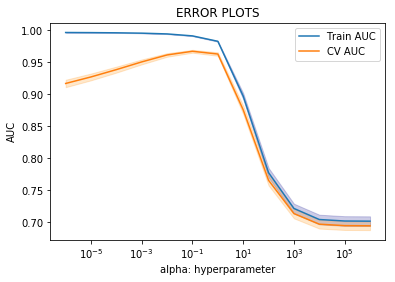

In [78]:
#Plotting performance of model both on train data and cross validation, and finding the best optimum K.
train_auc3= clf3.cv_results_['mean_train_score']
train_auc_std3= clf3.cv_results_['std_train_score']
cv_auc3 = clf3.cv_results_['mean_test_score'] 
cv_auc_std3= clf3.cv_results_['std_test_score']

# As alpha values range from very low to very high value.
# So we used pyplot.semilogx to convert alpha to log(alpha) for easy interpretation

plt.semilogx(a, train_auc3, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(a,train_auc3 - train_auc_std3, train_auc3 + train_auc_std3, alpha=0.2,color='darkblue')

plt.semilogx(a, cv_auc3, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(a,cv_auc3 - cv_auc_std3, cv_auc3 + cv_auc_std3, alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [79]:
l=0
for i in a:
    print (i,train_auc3[l],cv_auc3[l],train_auc3[l]-cv_auc3[l] )
    l+=1

1e-06 0.996663658861161 0.9169244882332374 0.07973917062792368
1e-05 0.9964874248565133 0.9271738184671212 0.0693136063893921
0.0001 0.9961868418420582 0.9386025188505478 0.057584322991510395
0.001 0.9956283937057039 0.9506678425159529 0.04496055118975095
0.01 0.9944397995624135 0.9615608760281116 0.032878923534301885
0.1 0.9913691910853185 0.9673008782872247 0.02406831279809385
1 0.98289047577176 0.9629709195304403 0.01991955624131969
10 0.8971390880576963 0.8756360751434512 0.021503012914245057
100 0.7772576370360679 0.7653352994581012 0.01192233757796668
1000 0.72133290618183 0.713284928788395 0.00804797739343499
10000 0.7040409634200159 0.6967405403934033 0.007300423026612601
100000 0.7016930098234488 0.6944657720349089 0.007227237788539953
1000000 0.7014500483228702 0.694231433302704 0.007218615020166186


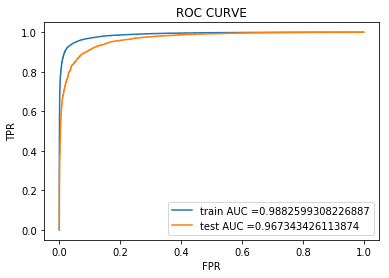

In [80]:
#training our model with the best optimal a, and find the AUC on test data and plot the ROC curve on both train and test. 
NBtfidf1 = MultinomialNB(alpha=0.1, class_prior=[0.5,0.5], fit_prior=True)
NBtfidf1.fit(X_train_fe_tfidf_S, y1_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr3, train_tpr3, thresholds3 = roc_curve(y1_train, NBtfidf1.predict_proba(X_train_fe_tfidf_S)[:,1])
test_fpr3, test_tpr3, thresholds3 = roc_curve(y1_test, NBtfidf1.predict_proba(X_test_fe_tfidf_S)[:,1])

plt.plot(train_fpr3, train_tpr3, label="train AUC ="+str(auc(train_fpr3, train_tpr3)))
plt.plot(test_fpr3, test_tpr3, label="test AUC ="+str(auc(test_fpr3, test_tpr3)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC CURVE")
plt.show()

Train confusion matrix


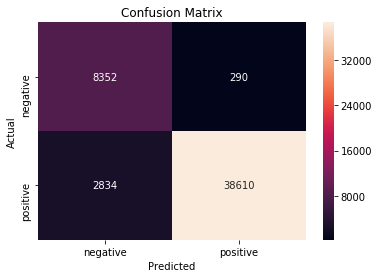

Test confusion matrix


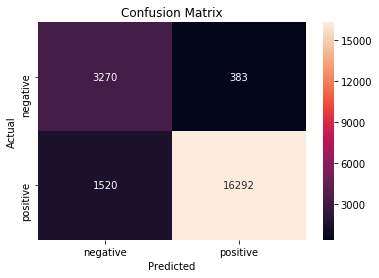

In [81]:
# Confusion matrix
print("Train confusion matrix")
matrix_train3= confusion_matrix(y1_train, NBtfidf1.predict(X_train_fe_tfidf_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_train3 = pd.DataFrame(matrix_train3,columns,index)
sns.heatmap(df_matrix_train3, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Test confusion matrix")
matrix_test3= confusion_matrix(y1_test, NBtfidf1.predict(X_test_fe_tfidf_S))
index = ['negative', 'positive']  
columns = ['negative', 'positive']
df_matrix_test3 = pd.DataFrame(matrix_test3,columns,index)
sns.heatmap(df_matrix_test3, annot=True, fmt='d')
plt.title("Confusion Matrix") 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [82]:
# Top 10 important features of positive class.
# Please write all the code with proper documentation
feat_prob3 = NBtfidf1.feature_log_prob_ #log probability of the features.
feat_name3 = tf_idf_vect1.get_feature_names()
positive_feat3 = np.argsort(feat_prob3[1])[::-1] #Returns sorted indexs of +ve class.
print("Top 10 positive features from TFIDF:")
for i in list(positive_feat3[0:10]):
    print(feat_name3[i])

Top 10 positive features from TFIDF:
not
great
good
coffee
love
like
product
tea
taste
flavor


In [83]:
# Top 10 important features of Negative class.
negative_feat3 = np.argsort(feat_prob3[0])[::-1] #Returns sorted indexs of +ve class.
print("Top 10 negative features from TFIDF:")
for i in list(negative_feat3[0:10]):
    print(feat_name3[i])

Top 10 negative features from TFIDF:
not
product
like
taste
would
no
one
coffee
buy
flavor


### [6] Summary:

In [84]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model","Vectorizer", "FE Data","Hyperparameter-Alpha", "Test AUC"]
x.add_row(["Naive Bayes","BOW", "No", 0.1, 0.9367])
x.add_row(["Naive Bayes","TFIDF", "No", 0.1, 0.9528])
x.add_row(["Naive Bayes","BOW", "Yes", 0.1, 0.9557])
x.add_row(["Naive Bayes","TFIDF", "Yes", 0.1, 0.9673])
print ("Summarize the results: ")
print(x)

Summarize the results: 
+-------------+------------+---------+----------------------+----------+
|    Model    | Vectorizer | FE Data | Hyperparameter-Alpha | Test AUC |
+-------------+------------+---------+----------------------+----------+
| Naive Bayes |    BOW     |    No   |         0.1          |  0.9367  |
| Naive Bayes |   TFIDF    |    No   |         0.1          |  0.9528  |
| Naive Bayes |    BOW     |   Yes   |         0.1          |  0.9557  |
| Naive Bayes |   TFIDF    |   Yes   |         0.1          |  0.9673  |
+-------------+------------+---------+----------------------+----------+


# Conclusions

- Highest Test AUC of 0.9673 found using vectorizer TFIDF from FE dataset.
- From all the confusion matrix, we found that the predicted value of negative class is more than actual value of negative class.
- The Hyperparameter a remained same even after applying FE.
- From the summary, we noted that our Test AUC has increased in all cases after applying Feauture engineering.

#### Reference:
- www.appliedaicourse.com
- https://stackoverflow.com
- http://zetcode.com/python
